In [1]:
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import optuna
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv(r"C:\Users\USER\Documents\Tradingstuff\IV_PI_Stratdf_for_training.csv")
df.set_index('Unnamed: 0',inplace=True)
df

,close_price,log_return,smoothed_IV,min_max_PI,rolling_std_30,rolling_annual_vol_30,Vol_Spread,rolling_mean_PI,rolling_std_PI,z_score_PI,...,min_max_PI_lag_6,Vol_Spread_lag_1,Vol_Spread_lag_2,Vol_Spread_lag_3,Vol_Spread_lag_4,Vol_Spread_lag_5,Vol_Spread_lag_6,MACD_Line,MACD_Signal,MACD_Histogram
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2023-07-30 14:00:00,29391.81,0.003541,35.33,-0.000273,0.002939,27.505899,7.824101,-0.000775,0.000442,1.136219,...,-0.000599,7.648142,5.940372,5.997925,6.129215,6.004814,6.040096,1.951589,-2.217337,4.168926
2023-07-30 15:00:00,29349.37,-0.001445,35.24,-0.000876,0.002939,27.508929,7.731071,-0.000774,0.000442,-0.229329,...,-0.000602,7.824101,7.648142,5.940372,5.997925,6.129215,6.004814,4.338682,-0.906133,5.244815
2023-07-30 16:00:00,29380.02,0.001044,35.76,-0.000683,0.002910,27.239903,8.520097,-0.000775,0.000442,0.206575,...,-0.000746,7.731071,7.824101,7.648142,5.940372,5.997925,6.129215,8.604481,0.995990,7.608492
2023-07-30 17:00:00,29396.52,0.000561,35.82,-0.000651,0.002910,27.232957,8.587043,-0.000775,0.000442,0.280452,...,-0.000645,8.520097,7.731071,7.824101,7.648142,5.940372,5.997925,13.164815,3.429755,9.735060
2023-07-30 18:00:00,29355.99,-0.001380,35.79,-0.000752,0.002908,27.215382,8.574618,-0.000773,0.000440,0.048292,...,-0.000671,8.587043,8.520097,7.731071,7.824101,7.648142,5.940372,13.354536,5.414711,7.939825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-08 10:00:00,86123.19,0.002091,51.89,-0.000839,0.006720,62.892348,-11.002348,-0.000928,0.000328,0.271869,...,-0.000876,-10.864620,-10.808420,-10.417088,-10.161838,-9.639580,-9.632056,-640.792881,-647.208150,6.415268
2025-03-08 11:00:00,85955.88,-0.001945,52.39,-0.000840,0.006720,62.893982,-10.503982,-0.000929,0.000328,0.270449,...,-0.000890,-11.002348,-10.864620,-10.808420,-10.417088,-10.161838,-9.639580,-628.656942,-643.497908,14.840966
2025-03-08 12:00:00,86209.72,0.002949,52.37,-0.000772,0.006718,62.877272,-10.507272,-0.000929,0.000328,0.478702,...,-0.001026,-10.503982,-11.002348,-10.864620,-10.808420,-10.417088,-10.161838,-591.735202,-633.145367,41.410165


In [3]:
df = df.loc['2023-07-29':'2025-01-01']
df

,close_price,log_return,smoothed_IV,min_max_PI,rolling_std_30,rolling_annual_vol_30,Vol_Spread,rolling_mean_PI,rolling_std_PI,z_score_PI,...,min_max_PI_lag_6,Vol_Spread_lag_1,Vol_Spread_lag_2,Vol_Spread_lag_3,Vol_Spread_lag_4,Vol_Spread_lag_5,Vol_Spread_lag_6,MACD_Line,MACD_Signal,MACD_Histogram
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2023-07-30 14:00:00,29391.81,0.003541,35.33,-0.000273,0.002939,27.505899,7.824101,-0.000775,0.000442,1.136219,...,-0.000599,7.648142,5.940372,5.997925,6.129215,6.004814,6.040096,1.951589,-2.217337,4.168926
2023-07-30 15:00:00,29349.37,-0.001445,35.24,-0.000876,0.002939,27.508929,7.731071,-0.000774,0.000442,-0.229329,...,-0.000602,7.824101,7.648142,5.940372,5.997925,6.129215,6.004814,4.338682,-0.906133,5.244815
2023-07-30 16:00:00,29380.02,0.001044,35.76,-0.000683,0.002910,27.239903,8.520097,-0.000775,0.000442,0.206575,...,-0.000746,7.731071,7.824101,7.648142,5.940372,5.997925,6.129215,8.604481,0.995990,7.608492
2023-07-30 17:00:00,29396.52,0.000561,35.82,-0.000651,0.002910,27.232957,8.587043,-0.000775,0.000442,0.280452,...,-0.000645,8.520097,7.731071,7.824101,7.648142,5.940372,5.997925,13.164815,3.429755,9.735060
2023-07-30 18:00:00,29355.99,-0.001380,35.79,-0.000752,0.002908,27.215382,8.574618,-0.000773,0.000440,0.048292,...,-0.000671,8.587043,8.520097,7.731071,7.824101,7.648142,5.940372,13.354536,5.414711,7.939825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,94166.88,0.003097,60.70,-0.000598,0.005941,55.608099,5.091901,-0.000121,0.000975,-0.488961,...,-0.000195,5.282239,5.395812,5.562172,5.894558,5.945169,6.160607,324.475675,298.801123,25.674552
2024-12-31 20:00:00,93564.04,-0.006422,60.56,-0.000291,0.005946,55.651962,4.908038,-0.000123,0.000974,-0.172535,...,-0.000278,5.091901,5.282239,5.395812,5.562172,5.894558,5.945169,242.400013,287.520901,-45.120888
2024-12-31 21:00:00,93899.68,0.003581,60.60,-0.000441,0.005942,55.614205,4.985795,-0.000126,0.000972,-0.323851,...,-0.000458,4.908038,5.091901,5.282239,5.395812,5.562172,5.894558,202.108027,270.438326,-68.330299


In [12]:
# Define target columns (assuming you have 6 target columns)
target_columns = ['label_2', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7']

# Define feature columns as all columns that are not the target columns
feature_columns = [col for col in df.columns if col not in target_columns]
X = df[feature_columns].values

In [5]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

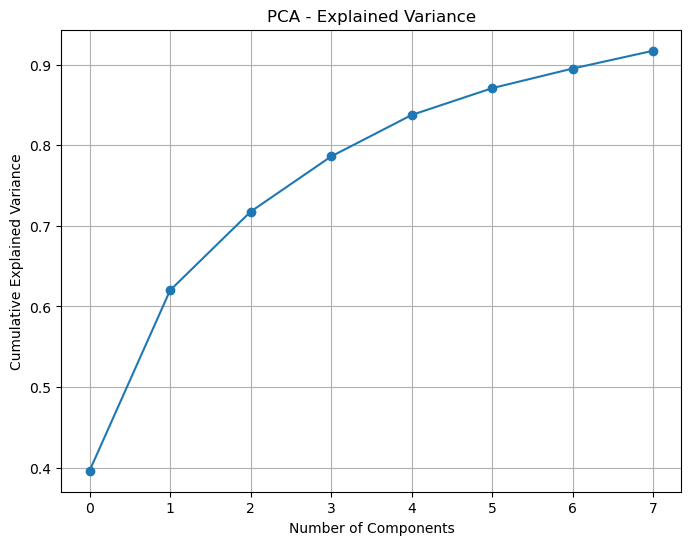

In [6]:
# 7. Apply PCA
pca = PCA(n_components=0.90)  # Retain 90% variance
X_pca = pca.fit_transform(X_scaled)

# 8. Visualize Explained Variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid(True)
plt.show()

In [9]:
# After fitting PCA
loadings = pd.DataFrame(
    pca.components_, 
    columns=feature_columns,  # the same feature_columns you used for X
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)

print("PCA Loadings (Components):")
print(loadings)

PCA Loadings (Components):
     close_price  log_return  smoothed_IV  min_max_PI  rolling_std_30  \
PC1     0.094304    0.005595     0.212383    0.206127        0.035812   
PC2    -0.191690    0.007644    -0.185926    0.002633       -0.348372   
PC3    -0.076411    0.030612    -0.154521    0.290768       -0.036600   
PC4     0.108569    0.107114     0.070449    0.021679        0.076017   
PC5    -0.001322   -0.006025     0.027273    0.095448        0.043014   
PC6    -0.007641    0.726405     0.008432    0.079297        0.008851   
PC7     0.170504    0.467859     0.001731    0.110450        0.012440   
PC8     0.319717   -0.415209     0.004506    0.071222        0.034189   

     rolling_annual_vol_30  Vol_Spread  rolling_mean_PI  rolling_std_PI  \
PC1               0.035812    0.201246         0.186138        0.123942   
PC2              -0.348372    0.216320        -0.109277       -0.063606   
PC3              -0.036600   -0.133363         0.042600        0.141496   
PC4            

In [17]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [18]:
tss = TimeSeriesSplit(n_splits=5)

encoders = {}
for label in target_columns:
    le = LabelEncoder()
    # Transform and store the encoder for each label
    df[label] = le.fit_transform(df[label])
    encoders[label] = le
# We'll iterate over each label column
for label in target_columns:
    print(f"\n=== Processing label: {label} ===")
    y = df[label].values  # This label's target

    # Build a pipeline to Standardize -> PCA -> Classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.90)),  # or a fixed integer, e.g. PCA(n_components=7)
        ('clf', XGBClassifier(
            use_label_encoder=False,  # avoids a warning in recent XGBoost versions
            eval_metric='mlogloss'    # suitable for both binary and multi-class
        ))
    ])
    
    # We'll do a manual loop over each time-series fold
    fold_index = 1
    for train_index, test_index in tss.split(X):
        # Split according to TimeSeriesSplit
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Fit the pipeline on the training fold
        pipeline.fit(X_train, y_train)
        
        # Predict on the test fold
        y_pred = pipeline.predict(X_test)
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        print(f"Fold {fold_index} confusion matrix for {label}:")
        print(cm)
        
        fold_index += 1

C:\Users\USER\AppData\Local\Temp\ipykernel_26188\1914353395.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label] = le.fit_transform(df[label])
C:\Users\USER\AppData\Local\Temp\ipykernel_26188\1914353395.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label] = le.fit_transform(df[label])
C:\Users\USER\AppData\Local\Temp\ipykernel_26188\1914353395.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in


=== Processing label: label_2 ===
Fold 1 confusion matrix for label_2:
[[   0   12    0]
 [   5 2054    1]
 [   0    9    0]]
Fold 2 confusion matrix for label_2:
[[   0   17    0]
 [   1 2034    3]
 [   0   25    1]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 confusion matrix for label_2:
[[   0   16    0]
 [   0 2056    0]
 [   0    9    0]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 confusion matrix for label_2:
[[   0   25    0]
 [   0 2035    0]
 [   0   21    0]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 5 confusion matrix for label_2:
[[   0   12    0]
 [   3 2049    0]
 [   0   17    0]]

=== Processing label: label_3 ===


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 confusion matrix for label_3:
[[   0   17    1]
 [   7 2024   12]
 [   0   20    0]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 confusion matrix for label_3:
[[   0   34    0]
 [   0 2000    3]
 [   0   44    0]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 confusion matrix for label_3:
[[   0   23    0]
 [   0 2039    1]
 [   0   18    0]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 confusion matrix for label_3:
[[   0   33    0]
 [   0 2010    0]
 [   0   38    0]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 5 confusion matrix for label_3:
[[   0   20    1]
 [   2 2029    0]
 [   0   29    0]]

=== Processing label: label_4 ===


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 confusion matrix for label_4:
[[   0   22    1]
 [  12 2013    4]
 [   0   28    1]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 confusion matrix for label_4:
[[   0   53    0]
 [   0 1963   10]
 [   0   55    0]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 confusion matrix for label_4:
[[   1   33    0]
 [   2 2016    0]
 [   0   29    0]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 confusion matrix for label_4:
[[   0   47    0]
 [   0 1981    2]
 [   0   50    1]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 5 confusion matrix for label_4:
[[   0   29    0]
 [   0 2013    1]
 [   0   38    0]]

=== Processing label: label_5 ===


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 confusion matrix for label_5:
[[   0   31    0]
 [   0 2008    0]
 [   0   42    0]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 confusion matrix for label_5:
[[   0   67    0]
 [   0 1937    5]
 [   0   71    1]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 confusion matrix for label_5:
[[   3   40    0]
 [  11 1987    0]
 [   0   40    0]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 confusion matrix for label_5:
[[   0   61    0]
 [   0 1953    0]
 [   0   67    0]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 5 confusion matrix for label_5:
[[   0   45    0]
 [   2 1971    3]
 [   0   60    0]]

=== Processing label: label_6 ===


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 confusion matrix for label_6:
[[   0   40    0]
 [   0 1976    0]
 [   0   65    0]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 confusion matrix for label_6:
[[   3   79    0]
 [   3 1899    1]
 [   1   95    0]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 confusion matrix for label_6:
[[   3   59    0]
 [   4 1957    1]
 [   0   57    0]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 confusion matrix for label_6:
[[   0   72    1]
 [   0 1907   13]
 [   0   88    0]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:55:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 5 confusion matrix for label_6:
[[   0   52    0]
 [   5 1946    5]
 [   0   73    0]]

=== Processing label: label_7 ===


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:56:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 confusion matrix for label_7:
[[   0   46    0]
 [   0 1960    0]
 [   0   75    0]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:56:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 confusion matrix for label_7:
[[   0   96    1]
 [   1 1861    5]
 [   0  115    2]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:56:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 confusion matrix for label_7:
[[   2   71    0]
 [   7 1935    0]
 [   0   66    0]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:56:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 confusion matrix for label_7:
[[   0   88    0]
 [   1 1865   29]
 [   0   95    3]]


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:56:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 5 confusion matrix for label_7:
[[   1   60    1]
 [   7 1914    8]
 [   0   90    0]]
